### Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
import warnings
import yaml
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.external as sce
import scipy.sparse as sp
import statsmodels.api as sm
import scanpy as sc
import numpy as np
import pandas as pd


import matplotlib.pyplot 
import scanpy.external as sce
from matplotlib.colors import TwoSlopeNorm
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go
from scipy import stats
warnings.filterwarnings('ignore')
import scvelo as scv
import plotly.express as px
import plotly.io as pio
import itertools
import decoupler as dc
import sys
pio.renderers.default = "notebook_connected"
import random
random.seed(1)


In [2]:
homeDir = os.getenv("HOME")

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

import matplotlib.pyplot as plt
sys.path.insert(1, "./utils/")


from CleanAdata import *
from SankeyOBS import *


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [3]:
try:
    nb_fname = ipynbname.name()
except:
    nb_fname = "".join(os.path.basename(globals()["__vsc_ipynb_file__"]).split(".")[:-1])

# 1. Load Metacells anndata

In [4]:
n_neighb = 30
n_pcs = 5

In [5]:
CombinedAdata = sc.read_h5ad("./1_CombinedMetaCells.h5ad")

sc.pp.normalize_total(CombinedAdata, target_sum=2e4)
sc.pp.log1p(CombinedAdata)
CombinedAdata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 3200 × 16324
    obs: 'kmeans_clusters', 'AggregatedClass', 'AggregatedLabel', 'Auth_Sample.ID', 'Auth_Age', 'Auth_Tissue.ID', 'Auth_Sample.Type', 'Auth_Assay', 'Auth_Batch', 'dataset_id', 'sample_id', 'brain_region', 'age', 'stage', 'batch_key', 'Auth_Assay_formatted', 'scDblFinder.class'
    uns: 'log1p'
    layers: 'median'

### Here we remove "AggregatedLabel" with less than 10 metacells

In [6]:
# Keep only clusters with at least 10 cells
AggregatedOBS = CombinedAdata.obs["AggregatedLabel"].value_counts().loc[CombinedAdata.obs["AggregatedLabel"].value_counts() > 10].index.tolist()
CombinedAdata = CombinedAdata[CombinedAdata.obs["AggregatedLabel"].isin(AggregatedOBS)]




# 2. Re-compute HVGs, neighbors and PCA

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:01)


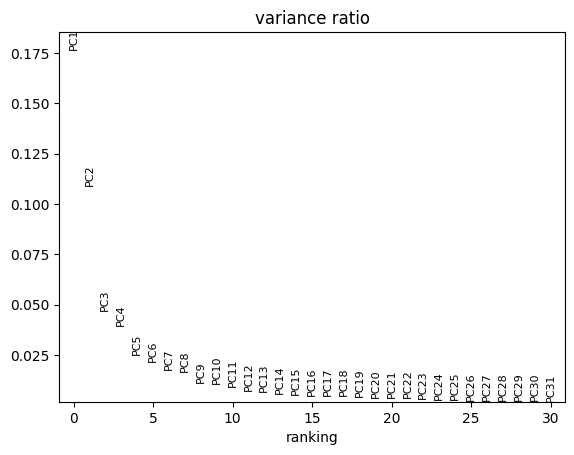

computing neighbors
    using 'X_pca' with n_pcs = 5
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [7]:
sc.pp.highly_variable_genes(CombinedAdata, n_top_genes=2000, flavor="seurat", batch_key="Auth_Sample.ID")
CombinedAdata.var["highly_variable"] = CombinedAdata.var["highly_variable_nbatches"] >= 2 
sc.tl.pca(CombinedAdata)
sc.pl.pca_variance_ratio(CombinedAdata)
sc.pp.neighbors(CombinedAdata, n_neighbors=n_neighb, n_pcs=n_pcs, metric="euclidean")
sc.tl.umap(CombinedAdata)


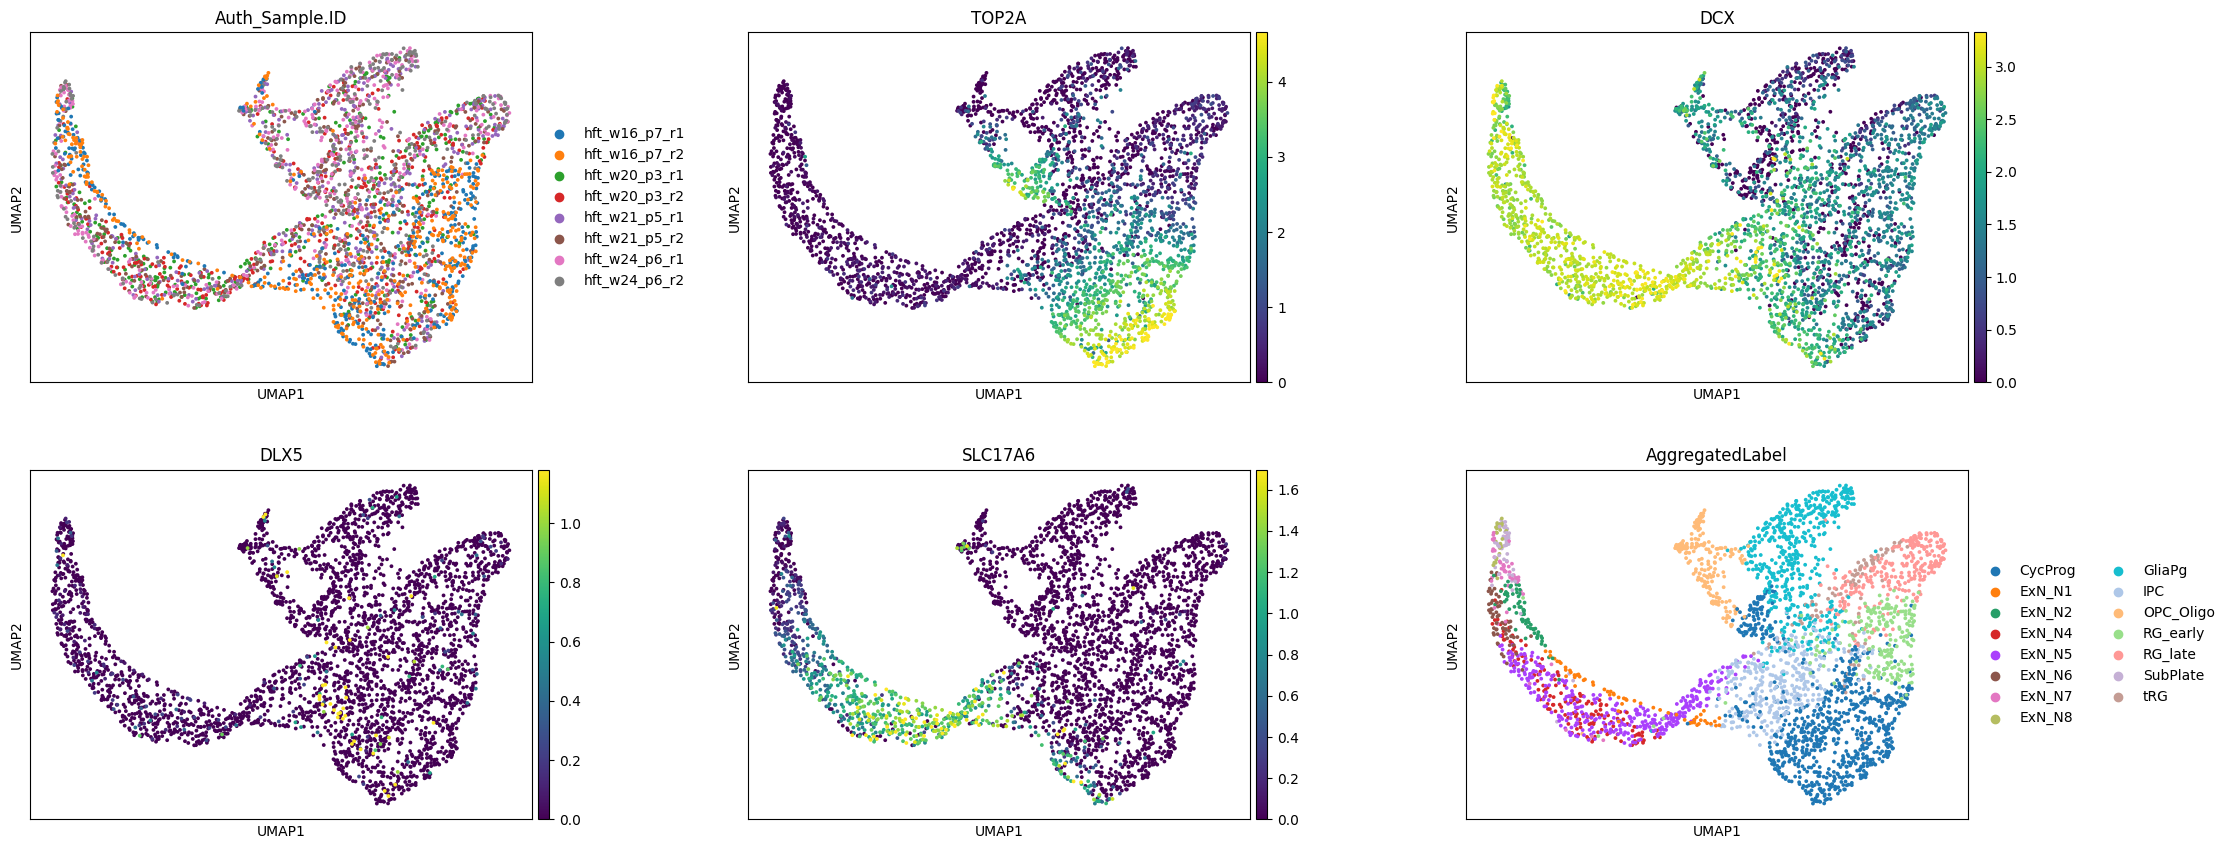

In [8]:

sc.pl.umap(CombinedAdata, color=["Auth_Sample.ID","TOP2A","DCX","DLX5","SLC17A6","AggregatedLabel"], ncols=3, wspace=.3, size = 30, vmin='p1', vmax='p99')

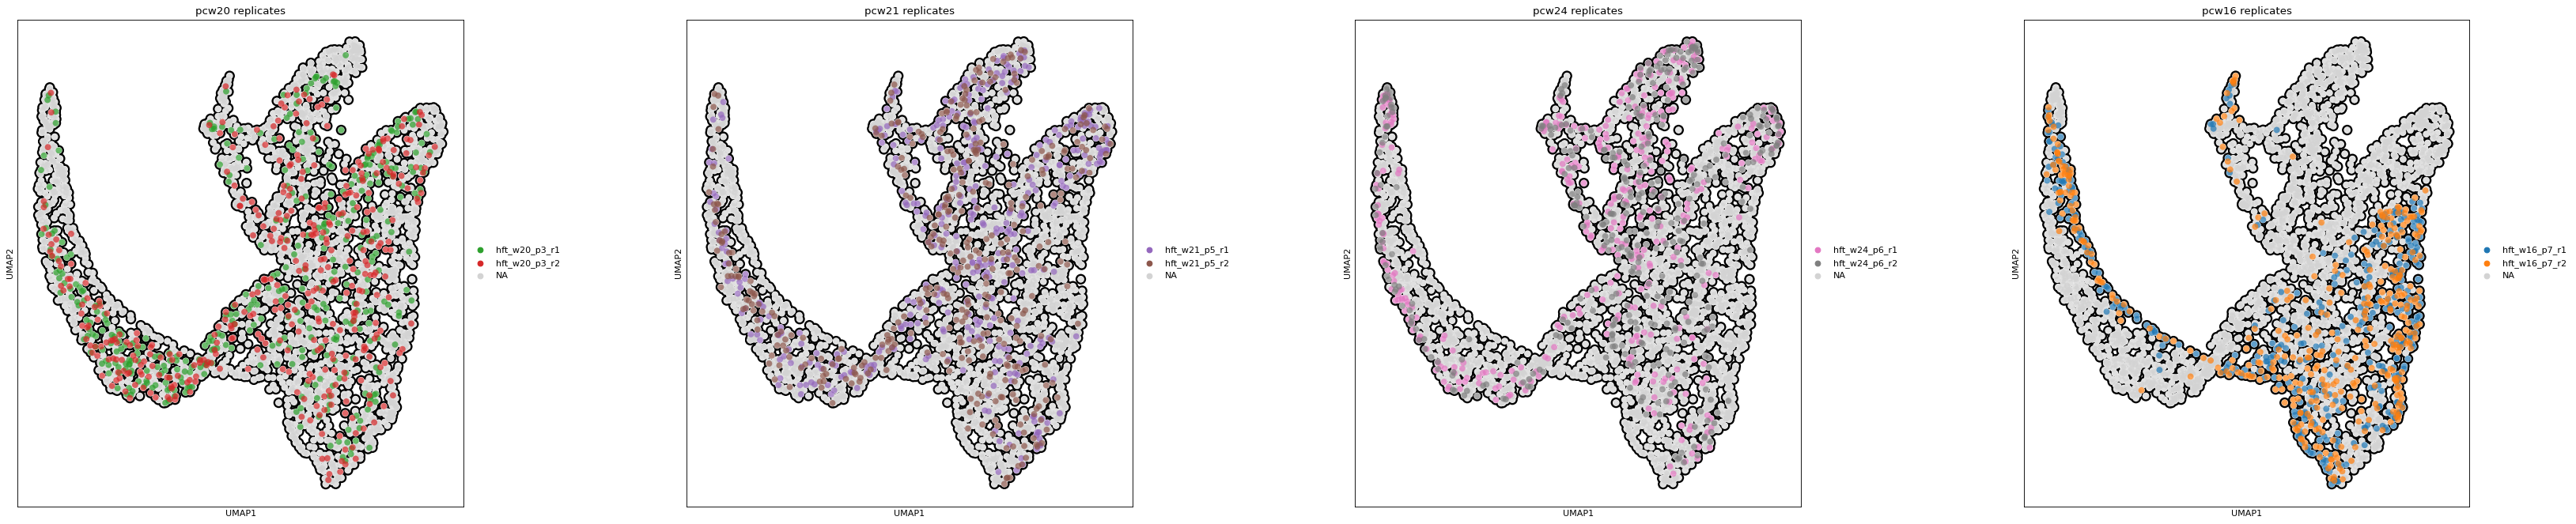

In [9]:
fig, axes = plt.subplots(1,len(CombinedAdata.obs.Auth_Age.unique()), figsize=(50, 10), dpi=80)
for Auth_Age in enumerate(CombinedAdata.obs.Auth_Age.unique()):
    SampleIDs = CombinedAdata.obs.loc[CombinedAdata.obs.Auth_Age == Auth_Age[1],"Auth_Sample.ID"].unique().tolist()
    axes[Auth_Age[0]] = sc.pl.embedding(CombinedAdata, size = 200, add_outline=True,ncols=2, color=["Auth_Sample.ID"],title="{} replicates".format(Auth_Age[1]),
                     groups=SampleIDs, vmin='p1', vmax='p99', show=False, ax=axes[Auth_Age[0]], basis = "umap")

plt.subplots_adjust(wspace=.5)
fig.show()

# 3. Perform a fresh integration on the new metacells anndata

In [10]:
CombinedAdata = CleanAdata(CombinedAdata, obstokeep=CombinedAdata.obs.columns.tolist(), obsmtokeep="X_pca")
CombinedAdata

AnnData object with n_obs × n_vars = 3200 × 16324
    obs: 'kmeans_clusters', 'AggregatedClass', 'AggregatedLabel', 'Auth_Sample.ID', 'Auth_Age', 'Auth_Tissue.ID', 'Auth_Sample.Type', 'Auth_Assay', 'Auth_Batch', 'dataset_id', 'sample_id', 'brain_region', 'age', 'stage', 'batch_key', 'Auth_Assay_formatted', 'scDblFinder.class'
    uns: 'Auth_Sample.ID_colors', 'AggregatedLabel_colors'
    obsm: 'X_pca'
    layers: 'median'

2024-11-10 19:57:57,484 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-10 19:57:59,257 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-10 19:57:59,266 - harmonypy - INFO - Iteration 1 of 20
2024-11-10 19:57:59,761 - harmonypy - INFO - Iteration 2 of 20
2024-11-10 19:58:00,267 - harmonypy - INFO - Iteration 3 of 20
2024-11-10 19:58:00,725 - harmonypy - INFO - Iteration 4 of 20
2024-11-10 19:58:01,218 - harmonypy - INFO - Iteration 5 of 20
2024-11-10 19:58:01,719 - harmonypy - INFO - Iteration 6 of 20
2024-11-10 19:58:02,201 - harmonypy - INFO - Iteration 7 of 20
2024-11-10 19:58:02,440 - harmonypy - INFO - Iteration 8 of 20
2024-11-10 19:58:02,793 - harmonypy - INFO - Iteration 9 of 20
2024-11-10 19:58:02,970 - harmonypy - INFO - Iteration 10 of 20
2024-11-10 19:58:03,170 - harmonypy - INFO - Iteration 11 of 20
2024-11-10 19:58:03,656 - harmonypy - INFO - Iteration 12 of 20
2024-11-10 19:58:03,854 - harmonypy - INFO - Converged after

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:15)


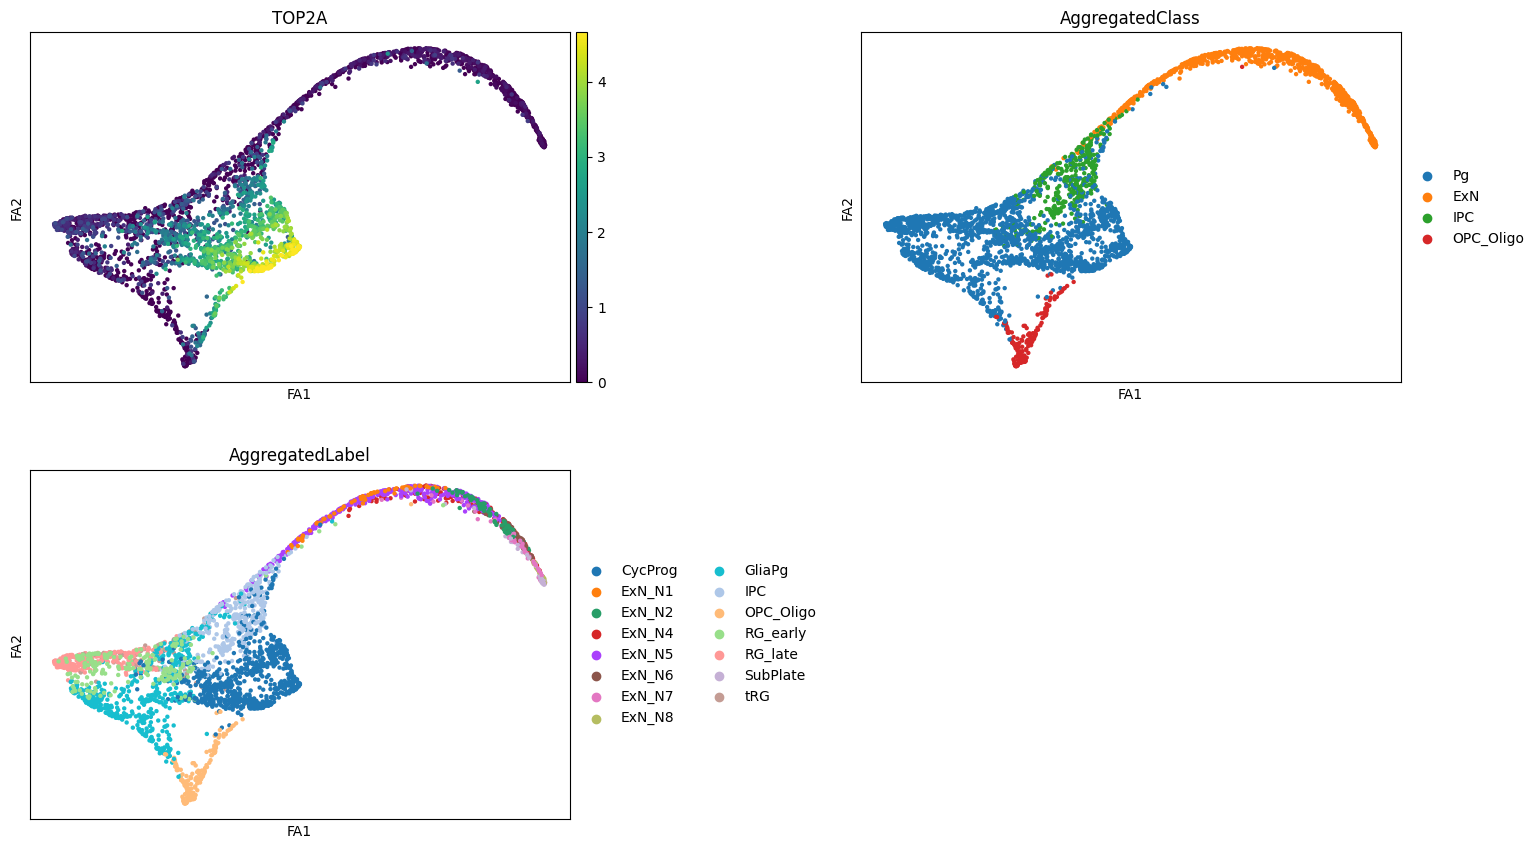

In [11]:
sce.pp.harmony_integrate(CombinedAdata, key="Auth_Batch", max_iter_harmony=20, theta =3)



sc.pp.neighbors(CombinedAdata, n_neighbors=n_neighb, n_pcs=n_pcs, use_rep="X_pca_harmony")

sc.tl.draw_graph(CombinedAdata)
sc.pl.draw_graph(CombinedAdata, color=["TOP2A","AggregatedClass","AggregatedLabel"], size=40, wspace=.4, ncols=2, vmin='p1', vmax='p99')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


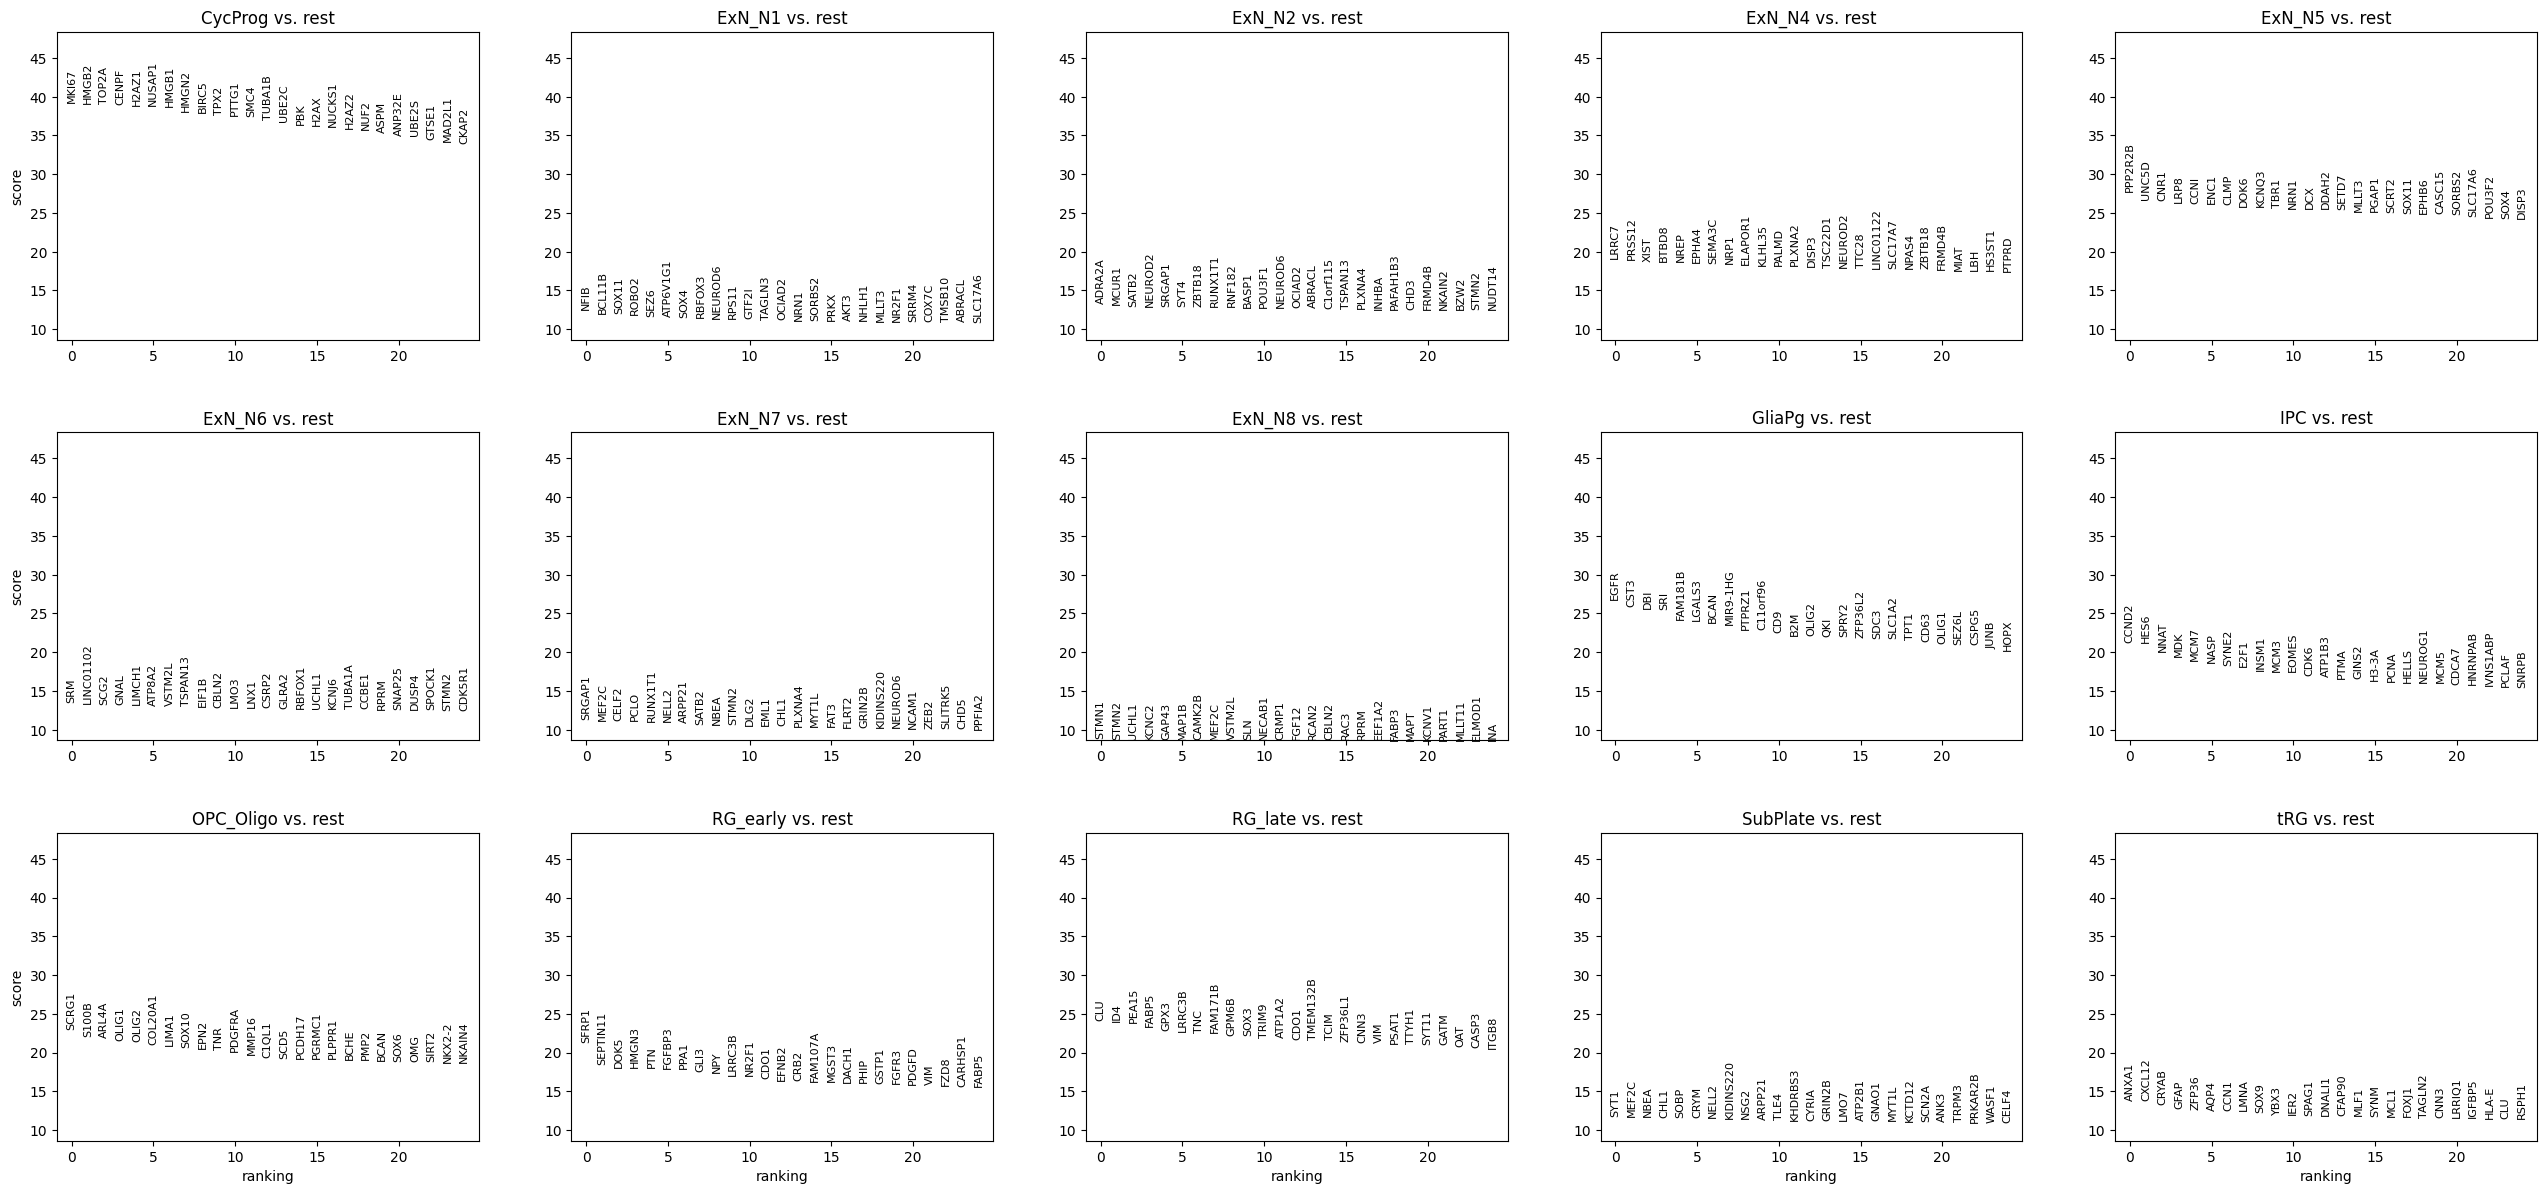

In [12]:
sc.tl.rank_genes_groups(CombinedAdata, groupby="AggregatedLabel", method="wilcoxon", n_genes=1000)
sc.pl.rank_genes_groups(CombinedAdata, n_genes=25, ncols=5)

## Compute trajectories

In [13]:



import palantir

dm_res = palantir.utils.run_diffusion_maps(CombinedAdata, knn=50, pca_key="X_pca_harmony", n_components=7)

ms_data = palantir.utils.determine_multiscale_space(CombinedAdata)
# Use scanpy functions to visualize umaps or FDL



computing neighbors


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


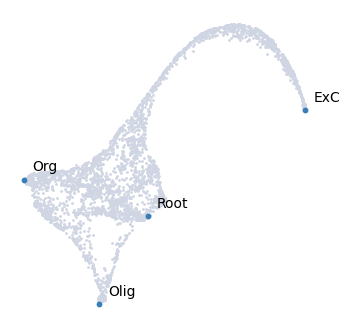

In [14]:

if "MAGIC_imputed_data" not in CombinedAdata.layers.keys():
    imputed_X = palantir.utils.run_magic_imputation(CombinedAdata)



#Cells selection
start_cell = CombinedAdata.obs_names[CombinedAdata[:,"TOP2A"].layers["MAGIC_imputed_data"].argmax()]
terminal_states = pd.Series(
    ["ExC", "Org","Olig"],
    index=[CombinedAdata.obs_names[CombinedAdata[:,"SOBP"].layers["MAGIC_imputed_data"].argmax()], 
           CombinedAdata.obs_names[CombinedAdata[:,"CLU"].layers["MAGIC_imputed_data"].argmax()],
           CombinedAdata.obs_names[CombinedAdata[:,"SCRG1"].layers["MAGIC_imputed_data"].argmax()]],
)
palantir.plot.highlight_cells_on_umap(CombinedAdata, pd.concat([terminal_states, pd.Series(["Root"], index=[start_cell])]), embedding_basis="X_draw_graph_fa")
plt.show()






Sampling and flocking waypoints...
Time for determining waypoints: 0.006784184773763021 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.23217047452926637 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


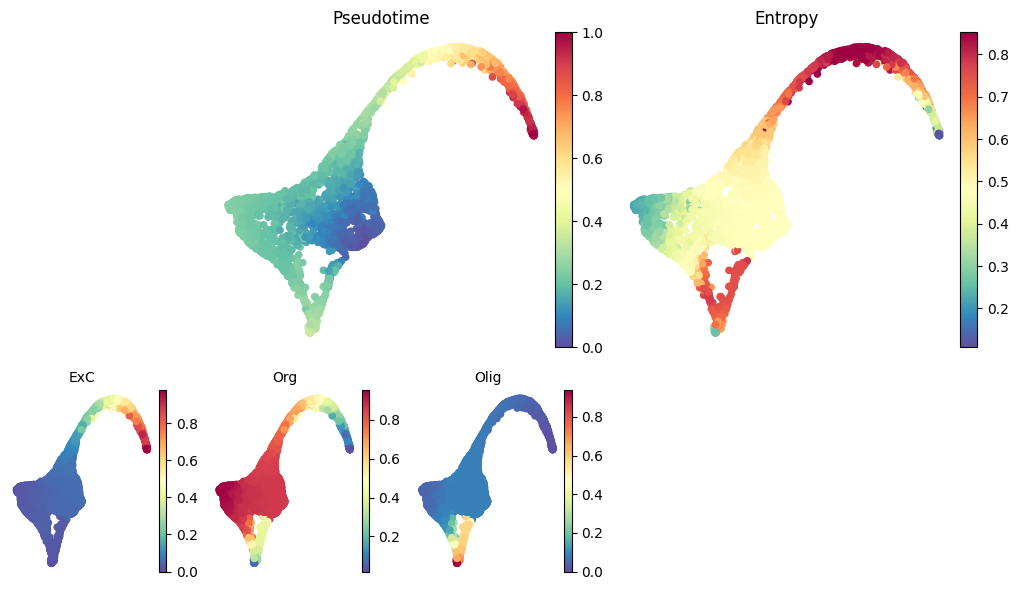

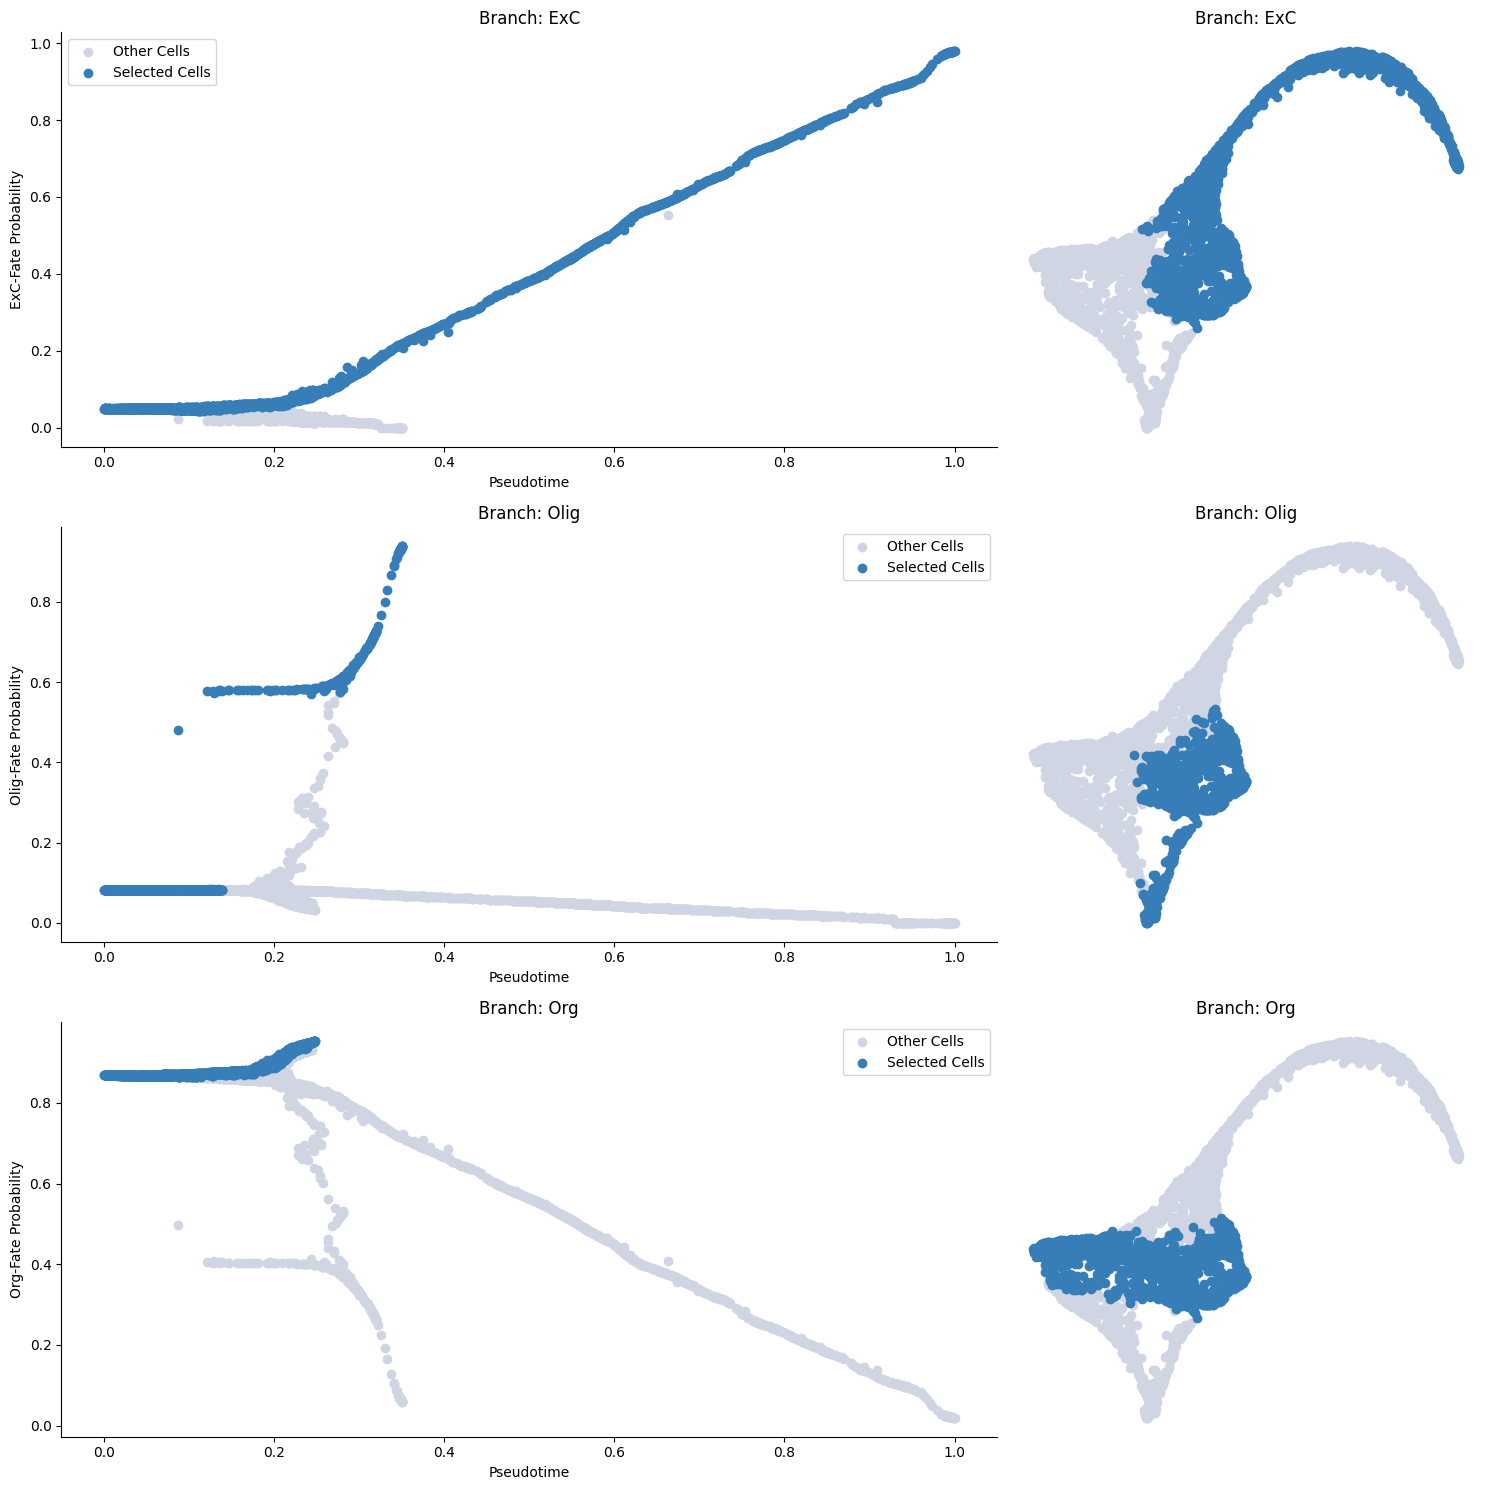

In [15]:

#Running
pr_res = palantir.core.run_palantir(CombinedAdata, early_cell=start_cell, terminal_states=terminal_states,knn=30,use_early_cell_as_start=True)
palantir.plot.plot_palantir_results(CombinedAdata, s=20,embedding_basis="X_draw_graph_fa")
plt.show()
palantir.presults.PSEUDOTIME_RES = CombinedAdata.n_obs

masks = palantir.presults.select_branch_cells(CombinedAdata, q=.01, eps=.01)


palantir.plot.plot_branch_selection(CombinedAdata,embedding_basis="X_draw_graph_fa")
plt.show()




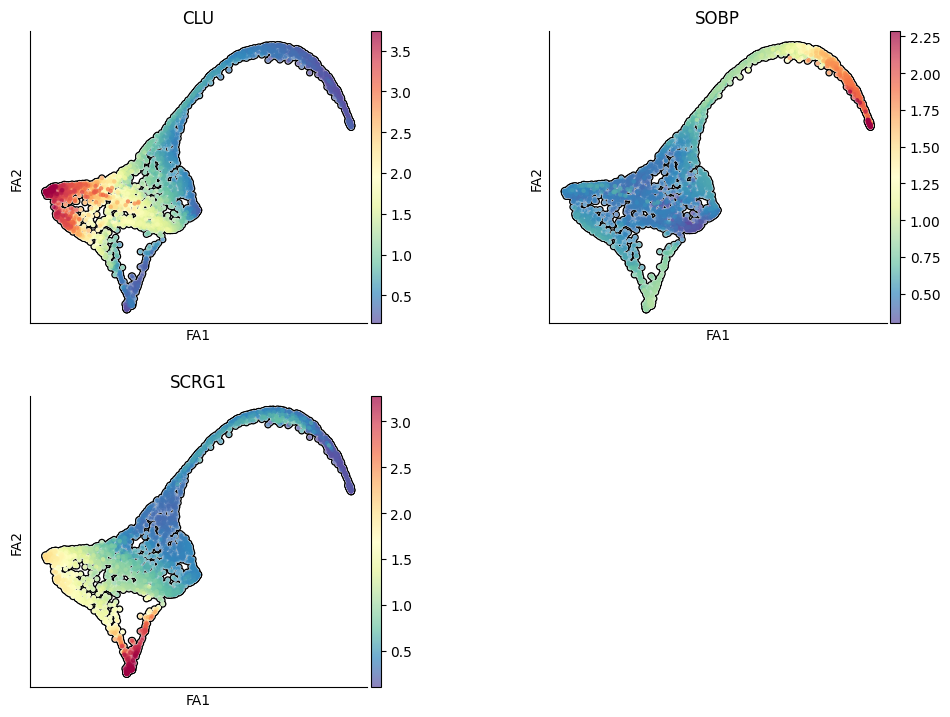

In [16]:
sc.pl.draw_graph(CombinedAdata, color=["CLU","SOBP","SCRG1"], layer="MAGIC_imputed_data", size=40, wspace=.4, ncols=2, vmin='p1', vmax='p99', add_outline=True)

# Save anndata with trajectories

In [17]:
CombinedAdata.write("./2_TrajectoriesAdata.h5ad")